In [1]:
# NN 4 outputs and with and without sorting of outputs
model_path = 'saved_model/Multi_leak/experiment5/Mask_MTL_sameLoss/'
project_name='Multi_leak_experiment5_Mask_MTL_withSwap_sameloss'

In [2]:
# Experiment 2 - 1 output layer with 1 loss function - mse. and do hyper parameter tuning.
from utils.data_preprocess import load_data
import pandas as pd 
import yaml
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt
from keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from kerastuner import HyperModel, Hyperband
from keras import backend as backend

In [3]:
single_leakage, two_leakage = load_data()
# two_leakage["leak_1"] = 1
two_leakage["leak_2"] = 1

# single_leakage["leak_1"] = 1
single_leakage["leak_2"] = 0

data = pd.concat([single_leakage, two_leakage], axis=0)
data['x2'] = data['x2'].replace(np.nan, 0)
data['y2'] = data['y2'].replace(np.nan, 0)

data = data.drop(columns=['mfc6_residual',
       'mfc7_residual', 'mfc8_residual', 'mfc9_residual', 'mfc10_residual',
       'mfc1_residual', 'mfc2_residual', 'mfc3_residual', 'mfc4_residual',
       'mfc5_residual', 'total flow rate'
       ])

y = data[['x1', 'y1', 'x2', 'y2', "leak_2"]]
x = data.drop(['x1', 'y1', 'x2', 'y2', "leak_2"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1) 

# sort x1, y1 and x2, y2. coordinates with lowest x will take the position of x1
def coords_swap(y1):
    s = y1['x2'] < y1['x1']
    y1.loc[s, ['x1','x2']] = y1.loc[s, ['x2','x1']].values
    y1.loc[s, ['y1','y2']] = y1.loc[s, ['y2','y1']].values
    return y1

y1_test_unsc = y_test

y1_data = [y_train, y_val, y_test]
y1_data_types = ['y_train', 'y_val', 'y_test']
for y1_data_types, y1 in zip(y1_data_types, y1_data):
    y1_data_types = coords_swap(y1)

y_test_org = y_test

y1_train = y_train[['x1', 'y1']]
y1_test = y_test[['x1', 'y1']]
y1_val = y_val[['x1', 'y1']]

y2_train = y_train[['x2', 'y2']]
y2_test = y_test[['x2', 'y2']]
y2_val = y_val[['x2', 'y2']]


y3_train = y_train[["leak_2"]]
y3_test = y_test[["leak_2"]]
y3_val = y_val[["leak_2"]]

y1_columns = y1_train.columns
y2_columns = y2_train.columns
y3_columns = y3_train.columns
X_columns = X_train.columns

scaler_coords1 = StandardScaler()
y1_train = scaler_coords1.fit_transform(y1_train)
y1_test = scaler_coords1.transform(y1_test)
y1_val = scaler_coords1.transform(y1_val)

y1_train = pd.DataFrame(y1_train, columns=y1_columns)
y1_test = pd.DataFrame(y1_test, columns=y1_columns)
y1_val = pd.DataFrame(y1_val, columns=y1_columns)

scaler_coords2 = StandardScaler()
y2_train = scaler_coords2.fit_transform(y2_train)
y2_test = scaler_coords2.transform(y2_test)
y2_val = scaler_coords2.transform(y2_val)

y2_train = pd.DataFrame(y2_train, columns=y2_columns)
y2_test = pd.DataFrame(y2_test, columns=y2_columns)
y2_val = pd.DataFrame(y2_val, columns=y2_columns)

scaler_flows = StandardScaler()
X_train = scaler_flows.fit_transform(X_train)
X_test = scaler_flows.transform(X_test)
X_val = scaler_flows.transform(X_val)

X_train = pd.DataFrame(X_train, columns=X_columns)
X_test = pd.DataFrame(X_test, columns=X_columns)
X_val = pd.DataFrame(X_val, columns=X_columns)

# y_train = [y1_train, y2_train]
# y_val = [y1_val, y2_val]
# y_test = [y1_test, y2_test]

y3_train = y3_train.reset_index().drop(columns='sample_number')
y3_val = y3_val.reset_index().drop(columns='sample_number')
y3_test = y3_test.reset_index().drop(columns='sample_number')

y_train_all = pd.concat([y1_train, y2_train, y3_train], axis=1)
y_test_all = pd.concat([y1_test, y2_test, y3_test], axis=1)
y_val_all = pd.concat([y1_val, y2_val, y3_val], axis=1)

In [4]:
X_train_np, y1_train_np, y2_train_np, y3_train_np = X_train.values, y1_train.values, y2_train.values, y3_train.values
X_val_np, y1_val_np, y2_val_np, y3_val_np = X_val.values, y1_val.values, y2_val.values, y3_val.values
X_test_np, y1_test_np, y2_test_np, y3_test_np = X_test.values, y1_test.values, y2_test.values, y3_test.values

# Create TensorFlow datasets from NumPy arrays.
batch_size = 32
buffer_size = len(X_train)  # Set the buffer size to the number of training examples for full shuffling.

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_np, y1_train_np, y2_train_np , y3_train_np))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_np, y1_val_np, y2_val_np, y3_val_np))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_np, y1_test_np, y2_test_np, y3_test_np))

# Shuffle, batch, and prefetch the training dataset.
train_dataset_org = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Batch the validation and test datasets.
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [5]:
def masked_mse(y_true, y_pred):
    mask = tf.keras.backend.cast(tf.keras.backend.not_equal(y_true, 0), tf.keras.backend.floatx())
    mse = tf.keras.backend.mean(tf.keras.backend.square(y_true - y_pred) * mask)
    return mse

losses = {
	"y1": "mse",
	"y2": masked_mse,
    "y3": 'mse'
    }

metrics = {
    "y1": 'mae',
    "y2": 'mae',
    "y3": 'mae'
    }

In [6]:
EPOCHS = 1000

# Define custom loss function


# Define model builder function for Keras Tuner
def model_builder(hp):
    tf.keras.backend.clear_session()
    # Tune the number of units in the first Dense layer
    # Define model
    inputs = tf.keras.Input(shape=(10,))
    shared_layer = inputs
    for i in range(hp.Int('num_layers', 1, 15)):
        shared_layer = layers.Dense(
            units=hp.Int("units_" + str(i), min_value=32, max_value=512, step=32),
            activation='relu',
            # add elu
            kernel_initializer='he_uniform'
        )(shared_layer)

    task_layer1 = shared_layer
    for j in range(hp.Int(f'task_{i}_num_layers', 0, 10)):
        task_layer1 = layers.Dense(units=hp.Int(f'task_{i}_layer_{j}_neurons', min_value=8, max_value=256, step=8), 
                                    activation='relu',
                                    kernel_initializer='he_uniform')(task_layer1)
    out1 = layers.Dense(2, name='y1', activation = 'linear', kernel_initializer='he_uniform')(task_layer1)
    out2 = layers.Dense(2, name='y2', activation = 'linear', kernel_initializer='he_uniform')(task_layer1)

    task_layer2 = shared_layer
    for j in range(hp.Int(f'task_{i}_num_layers', 0, 10)):
        task_layer2 = layers.Dense(units=hp.Int(f'task_{i}_layer_{j}_neurons', min_value=2, max_value=64, step=2),
                                    activation='relu',
                                    kernel_initializer='he_uniform')(task_layer2)
    out3 = layers.Dense(1, name='y3', activation = 'sigmoid', kernel_initializer='he_uniform')(task_layer2)

    model = tf.keras.Model(inputs=inputs, outputs=[out1, out2, out3])

    # loss1_weight = hp.Choice('loss1_weight', values=[0.6, 0.7, 0.8, 0.9])
    # loss2_weight = 1 - loss1_weight
    loss1_weight = 0.9
    loss2_weight = 0.1

    lossWeights = {"y1": loss1_weight, "y2": loss1_weight, "y3": loss2_weight}

    # Tune the learning rate for the optimizer
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-1, sampling="log")

    # model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss=['mse', masked_mse])
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=learning_rate),
                    loss=losses, 
                    loss_weights=lossWeights,
                    metrics = metrics)
    
    return model

tuner = Hyperband(
    model_builder,
    objective =  kt.Objective("val_loss", direction="min"),
    max_epochs=EPOCHS+100,
    factor=2,
    directory="../../tensorflow_log_files/studienarbeit/",
    project_name=project_name,
    seed = 0
)

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform hyperparameter search
tuner.search(train_dataset.map(lambda x, y1, y2, y3: (x, {'y1': y1, 'y2': y2, 'y3': y3})),
            #  X_train, y_train, 
            #  validation_data = (X_val, y_val), 
            validation_data = val_dataset.map(lambda x, y1, y2, y3: (x, {'y1': y1, 'y2': y2, 'y3': y3})), 
             verbose = 1, callbacks=[stop_early],
             epochs=EPOCHS, shuffle = True)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps)

# Build the best model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

from tensorflow.keras.callbacks import ModelCheckpoint
# Define the callback to save the model weights with the lowest validation loss
checkpoint_callback = ModelCheckpoint(
    filepath='best_multi_model_weights.h5',  # Filepath to save the weights
    monitor='val_loss',               # Metric to monitor for saving
    save_best_only=True,              # Save only the best model
    save_weights_only=True,           # Save only the weights (not the full model)
    mode='min',                       # Mode to minimize the monitored metric
    verbose=1                          # Verbosity level (optional)
)

# Train the best model on the full dataset
history = best_model.fit(train_dataset.map(lambda x, y1, y2, y3: (x, {'y1': y1, 'y2': y2, 'y3': y3})),
            #  X_train, y_train,
            #  validation_data = (X_val, y_val), 
            validation_data = val_dataset.map(lambda x, y1, y2, y3: (x, {'y1': y1, 'y2': y2, 'y3': y3})), 
            # callbacks=[stop_early],
            verbose = 1, epochs=EPOCHS, shuffle = True,
            callbacks=[checkpoint_callback] )

print(f"""
    The hyperparameter search is complete. The optimal learning rate for the optimizer
    is {best_model.optimizer.lr.numpy()}.
    """)

INFO:tensorflow:Reloading Tuner from ../../tensorflow_log_files/studienarbeit/Multi_leak_experiment5_Mask_MTL_withSwap_sameloss/tuner0.json
Search space summary
Default search space size: 182
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 15, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
task_0_num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 

In [7]:
best_model.save(model_path)
# best_model = tf.keras.models.load_model(model_path)
best_model.summary()

INFO:tensorflow:Assets written to: saved_model/Multi_leak/experiment5/Mask_MTL_sameLoss/assets
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 160)          1760        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 512)          82432       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 416)          213408      ['dense_1[0][0]']                

In [8]:
# tuner.results_summary()

In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
y_predictions_train = best_model.predict(train_dataset_org.map(lambda x, y1, y2, y3: (x, {'y1': y1, 'y2': y2, 'y3': y3})))
# print("train", "{:10.4f}".format(mean_squared_error(y_train, y_predictions, squared=True)))
y_predictions_val = best_model.predict(val_dataset.map(lambda x, y1, y2, y3: (x, {'y1': y1, 'y2': y2, 'y3': y3})))
# print("val", "{:10.4f}".format(mean_squared_error(y_val, y_predictions, squared=True)))
y_predictions = best_model.predict(test_dataset.map(lambda x, y1, y2, y3: (x, {'y1': y1, 'y2': y2, 'y3': y3})))

y_predictions_train = np.concatenate((y_predictions_train[0], y_predictions_train[1], y_predictions_train[2]), axis=1)
y_predictions_val = np.concatenate((y_predictions_val[0], y_predictions_val[1], y_predictions_val[2]), axis=1)
y_predictions = np.concatenate((y_predictions[0], y_predictions[1], y_predictions[2]), axis=1)

y_predictions_train[:,-1][np.abs(y_predictions_train[:,-1]) < 0.5] = 0
y_predictions_train[:,-1][np.abs(y_predictions_train[:,-1]) > 0.5] = 1

y_predictions_val[:,-1][np.abs(y_predictions_val[:,-1]) < 0.5] = 0
y_predictions_val[:,-1][np.abs(y_predictions_val[:,-1]) > 0.5] = 1

y_predictions[:,-1][np.abs(y_predictions[:,-1]) < 0.5] = 0
y_predictions[:,-1][np.abs(y_predictions[:,-1]) > 0.5] = 1

loss_test = "{:10.4f}".format(mean_squared_error(y_test_all, y_predictions, squared=True))
metric_test = "{:10.4f}".format(mean_absolute_error(y_test_all, y_predictions))

loss_val = "{:10.4f}".format(mean_squared_error(y_val_all, y_predictions_val, squared=True))
metric_val = "{:10.4f}".format(mean_absolute_error(y_val_all, y_predictions_val))

loss_train = "{:10.4f}".format(mean_squared_error(y_train_all, y_predictions_train, squared=True))
metric_train = "{:10.4f}".format(mean_absolute_error(y_train_all, y_predictions_train))

print(metric_test, metric_val, metric_train)

4/4 [==============================] - 0s 2ms/step
    0.0936     0.0940     0.0376


In [10]:
results_train = best_model.evaluate(train_dataset.map(lambda x, y1, y2, y3: (x, {'y1': y1, 'y2': y2, 'y3': y3})), verbose=1)
results_val = best_model.evaluate(val_dataset.map(lambda x, y1, y2, y3: (x, {'y1': y1, 'y2': y2, 'y3': y3})), verbose=1)
results_test = best_model.evaluate(test_dataset.map(lambda x, y1, y2, y3: (x, {'y1': y1, 'y2': y2, 'y3': y3})), verbose=1)

4/4 [==============================] - 0s 4ms/step - loss: 0.0609 - y1_loss: 0.0293 - y2_loss: 0.0383 - y3_loss: 0.0000e+00 - y1_mae: 0.1038 - y2_mae: 0.1301 - y3_mae: 0.0000e+00


In [24]:
coords1 = y_predictions[:,:2]
coords2 = y_predictions[:,2:4]

predictions1_unsc = scaler_coords1.inverse_transform(coords1)
predictions2_unsc = scaler_coords2.inverse_transform(coords2)

predictions1_unsc = pd.DataFrame(predictions1_unsc, columns=y1_columns)
predictions2_unsc = pd.DataFrame(predictions2_unsc, columns=y2_columns)

predictions_unsc = pd.concat([predictions1_unsc, predictions2_unsc], axis=1)
# predictions_unsc = scaler_coords1.inverse_transform(y_predictions)
# y1_test_unsc = y1_test_unsc.reset_index().drop(columns='sample_number')
diff = predictions_unsc - y1_test_unsc
diff = diff.drop(columns=['leak_2'])

distances_1 = np.sqrt(np.sum(diff.to_numpy()[:,:2] ** 2, axis=-1))/10
distances_2 = np.sqrt(np.sum(diff.to_numpy()[:,2:4] ** 2, axis=-1))/10
print(distances_1)
# print(len(distances))

y_mean1 = [distances_1.mean(axis=0)]*len(distances_1)
y_mean2 = [distances_2.mean(axis=0)]*len(distances_1)
# ind = np.argpartition(distances, -40)[-40:]
# top5 = distances[ind]
# average_of_75 = [top5.mean(axis=0)]*len(distances)
# average_of_75 = [30]*len(distances)
# print(top5.mean(axis=0), distances.mean(axis=0))


[ 16.631  42.662 118.145  38.22  138.033  22.568  98.094  24.225 233.804
  19.245 107.069 115.595   8.52   36.349  70.809  32.599  31.737  41.12
  65.309  30.938  20.155  53.581 124.415  24.93   82.241  27.621   7.957
  18.206  29.448  37.698  20.583  23.009  38.13   11.991  57.085  24.41
  95.338 126.342  33.717  81.032  74.465  95.642  19.188  25.359 152.006
  11.084  26.827  75.126 112.914  29.054 195.515  55.484  78.013  56.962
 166.221  35.409  51.599  36.692  74.019  16.108  14.885  75.8     9.204
 121.349  25.476 100.721 203.335  60.378  64.803 105.206  14.118  36.737
   8.195  58.433 237.14   74.007  10.037  14.893   1.855  27.504  53.883
  13.377  18.005  98.244  23.121   9.909  96.64   41.498  17.403  43.566
  35.939  14.286  22.138  77.524  37.     42.495  51.677  49.975 107.785
  93.08   44.58   16.172  33.661  41.566 145.461  69.992  31.415  34.882
 153.267  21.694  59.519 115.187  41.163  28.374  88.912  10.381  99.337]


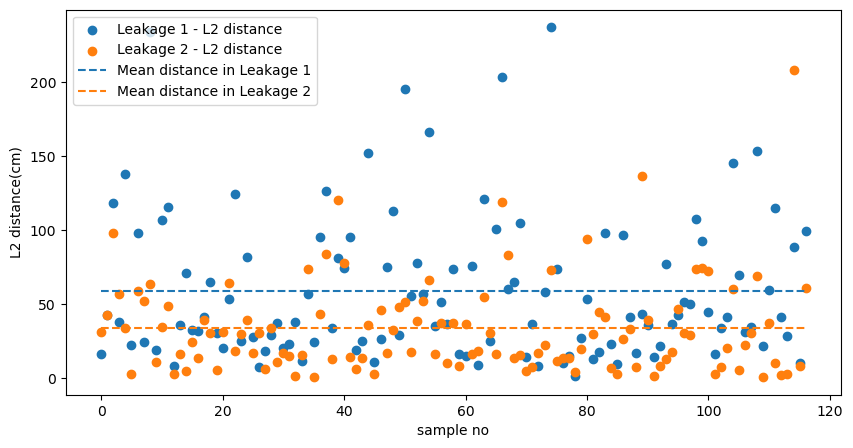

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.scatter(range(len(distances_1)),distances_1, label = 'Leakage 1 - L2 distance')
plt.scatter(range(len(distances_2)),distances_2, label = 'Leakage 2 - L2 distance')
plt.plot(range(len(distances_1)),y_mean1, label='Mean distance in Leakage 1', linestyle='--')
plt.plot(range(len(distances_2)),y_mean2, label='Mean distance in Leakage 2', linestyle='--')
# plt.plot(range(len(distances)),average_of_75, label='75% Data', linestyle='-.', color = 'k')
plt.legend(loc="upper left")
# plt.title("Distance between the Model predictions and True value", fontsize = 15)
plt.xlabel('sample no')
plt.ylabel('L2 distance(cm)')
plt.savefig('./results/multi_leakage_distance_plot.png')
plt.show()

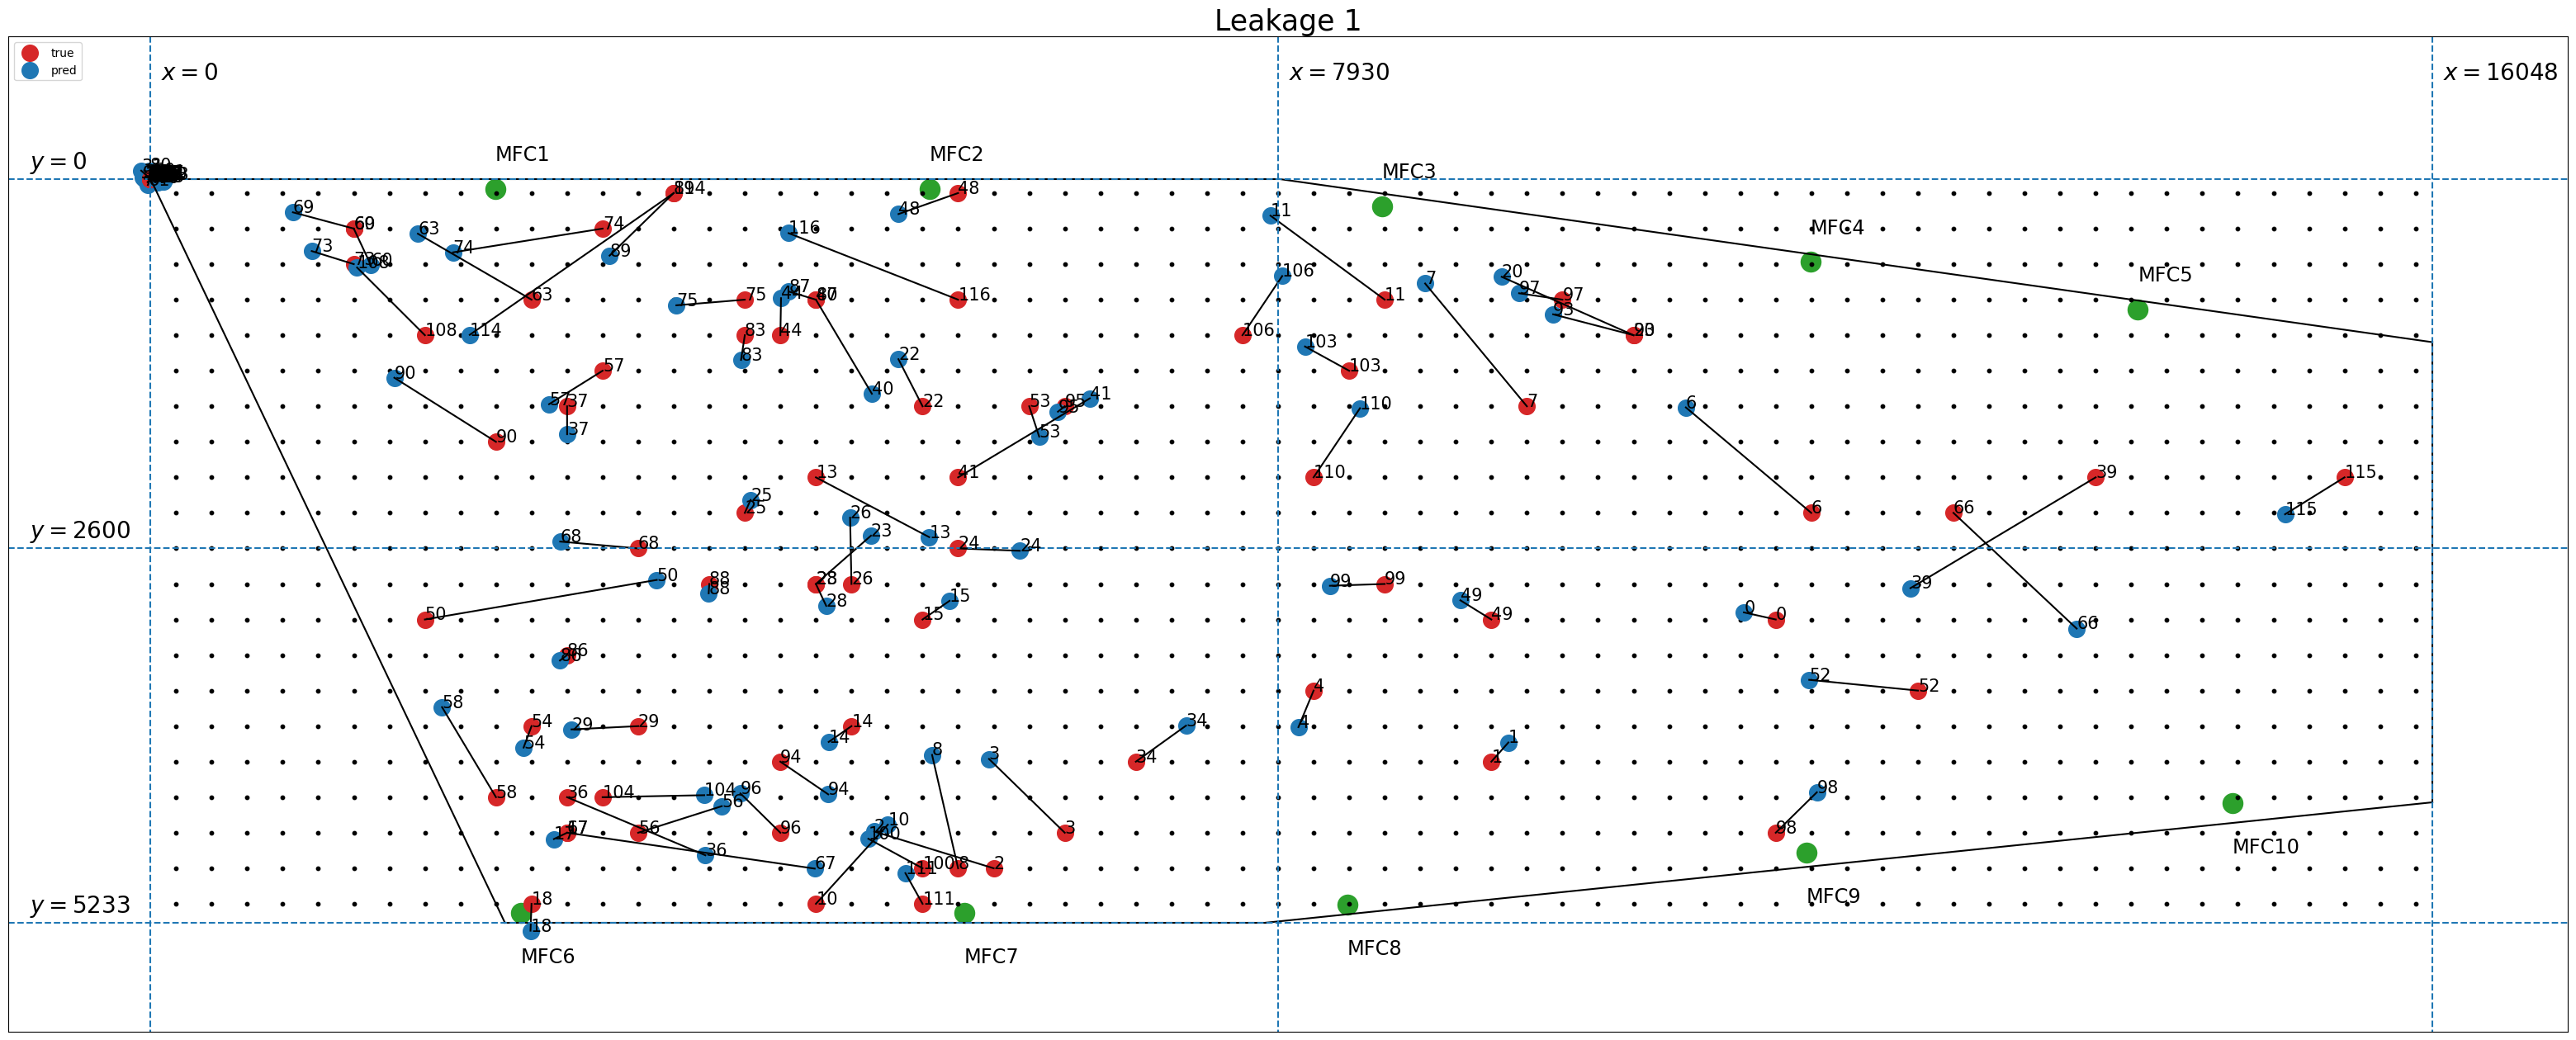

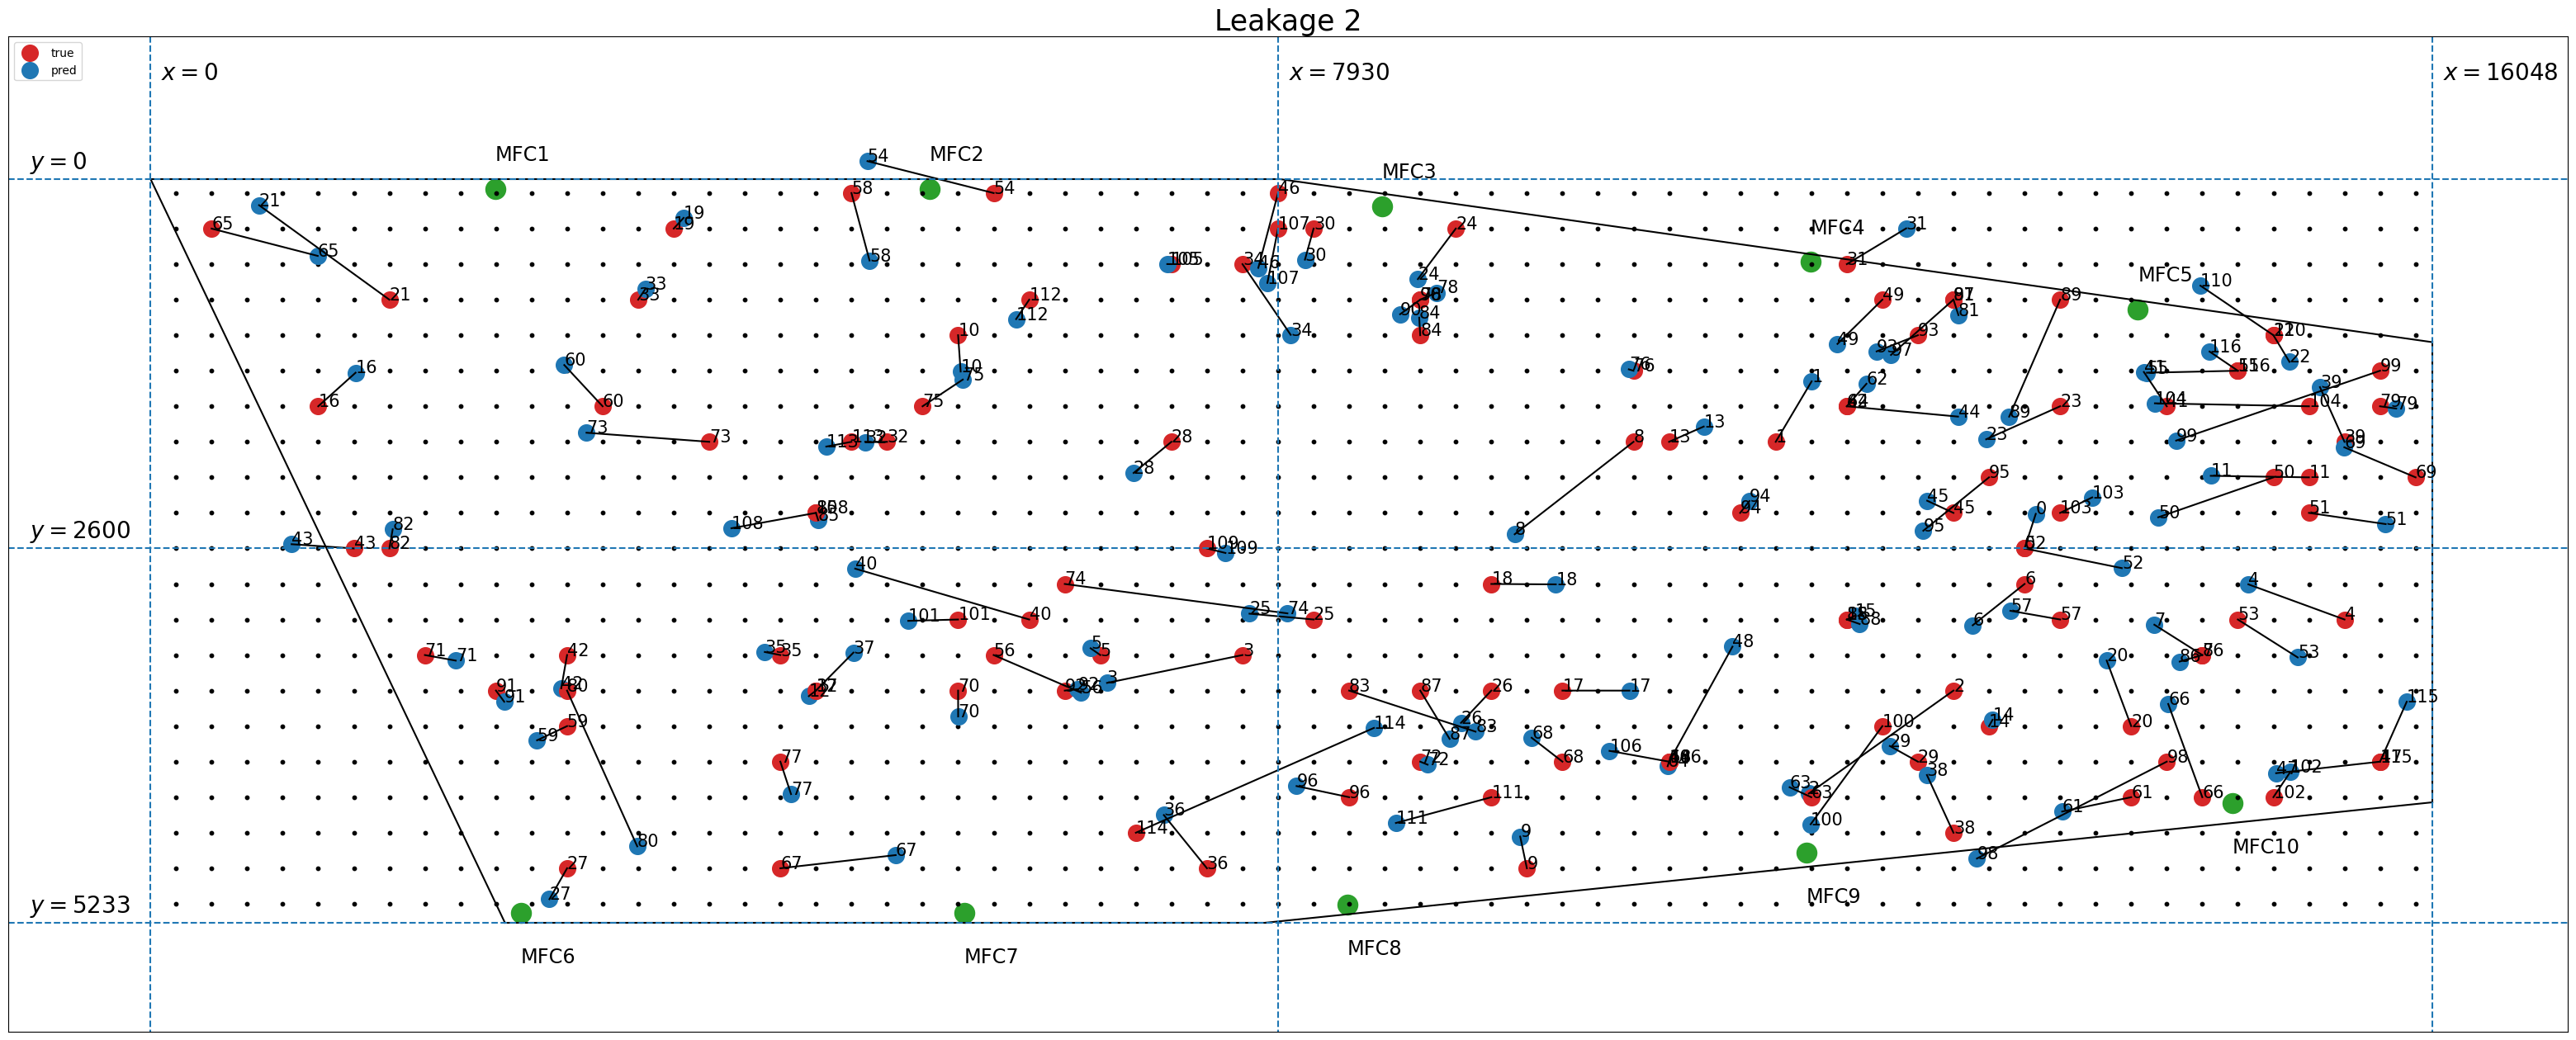

In [67]:


x_range = np.arange(180, 16048, 250)
y_range = np.arange(100, 5233, 250)
X, Y = np.meshgrid(x_range, y_range)


def plot_test_pred(test, pred, title):
    plt.figure(figsize=(40, 20))
    
    # plt.title(f'Sample Number {sample_number}', fontsize=20)
    
    # plot sensor positions
    sensors = np.array([[2426, 70], [5480, 70], [8661, 191], [11676, 584], [13976, 917], [2603, 5163], [5723, 5163], [8417, 5103], [11646, 4740], [14641, 4391]])
    for i in range(len(sensors)):
        plt.scatter(sensors[i, 0], sensors[i, 1], color='tab:green', s=300)
        if i < 5:
            plt.text(sensors[i, 0], sensors[i, 1] - 200, 'MFC'+str(i+1), fontsize='xx-large')
        else:
            plt.text(sensors[i, 0], sensors[i, 1] + 350, 'MFC'+str(i+1), fontsize='xx-large')

    # plot leakage positions
    plt.scatter(X, Y, color='black', s=10)
    
    for i in range(len(test)):
        if i != len(test)-1:
            plt.scatter(test[i][0], test[i][1], color='tab:red', s=200)
            plt.scatter(pred[i][0], pred[i][1], color='tab:blue', s=200)
            line = np.vstack((test[i], pred[i])).transpose()
            plt.plot(line[0], line[1], color = 'black')
            plt.annotate(str(i), (pred[i][0], pred[i][1] + 0.2), fontsize=15)
            plt.annotate(str(i), (test[i][0], test[i][1] + 0.2), fontsize=15)
        else:
            plt.scatter(test[i][0], test[i][1], color='tab:red', s=200, label="true")
            plt.scatter(pred[i][0], pred[i][1], color='tab:blue', s=200, label="pred")
            line = np.vstack((test[i], pred[i])).transpose()
            plt.plot(line[0], line[1], color = 'black')
            plt.annotate(str(i), (pred[i][0], pred[i][1] + 0.2), fontsize=15)
            plt.annotate(str(i), (test[i][0], test[i][1] + 0.2), fontsize=15)

    # print(X.shape)

    # plot wing contour
    plot_wing_contour()
    plt.title(title, fontsize = 25)

    # include grid coordinate system
    plt.hlines(0, -1000, 17000, linestyle='dashed')
    plt.hlines(2600, -1000, 17000, linestyle='dashed')
    plt.hlines(5233, -1000, 17000, linestyle='dashed')
    plt.vlines(0, -1000, 6000, linestyle='dashed')
    plt.vlines(7930, -1000, 6000, linestyle='dashed')
    plt.vlines(16048, -1000, 6000, linestyle='dashed')
    plt.text(-850, -75, '$y = 0$', fontsize=20)
    plt.text(-850, 2600-75, '$y = 2600$', fontsize=20)
    plt.text(-850, 5233-75, '$y = 5233$', fontsize=20)
    plt.text(75, -700, '$x=0$', fontsize=20)
    plt.text(7930+75, -700, '$x=7930$', fontsize=20)
    plt.text(16048+75, -700, '$x=16048$', fontsize=20)
    # plt.text(180, 5800, f'(x1, y1) = ({x1}, {y1}) = ({j1-31}, {-i1+10})', fontsize=20)
    plt.legend(loc="upper left")
    # invert y axis
    plt.gca().invert_yaxis()
    # plt.savefig('./results/hypermodel_results.png')

def plot_multi_leak(test, pred):
    plot_test_pred(test[['x1', 'y1']].to_numpy(), pred[['x1', 'y1']].to_numpy(), 'Leakage 1')
    plot_test_pred(test[['x2', 'y2']].to_numpy(), pred[['x2', 'y2']].to_numpy(), 'Leakage 2')
    plt.show()

def plot_wing_contour():
    plt.plot([0, 7930], [0, 0], 'k')
    plt.plot([7930, 16048], [0, 1149], 'k')
    plt.plot([16048, 16048], [1149, 4386], 'k')
    plt.plot([16048, 7843], [4386, 5233], 'k')
    plt.plot([7843, 2493], [5233, 5233], 'k')
    plt.plot([2493, 0], [5233, 0], 'k')
    plt.xlim([-1000, 17000])
    plt.ylim([-1000, 6000])
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_aspect('equal')

plot_multi_leak(y1_test_unsc, predictions_unsc)

In [68]:

# Create a list to store the layers of the new model
new_layers = []

# Define the input layer of the new model
input_layer = best_model.input
new_layers.append(input_layer)

# Iterate through the layers of each branch and insert dropout layers
for i, layer in enumerate(best_model.layers):
    if i == 0:
        continue
    # Add the current layer to the new model
    new_layers.append(layer)
    if layer.name not in ['y1', 'y2', 'y3']:
        # Add a dropout layer with the specified dropout rate
        new_layers.append(tf.keras.layers.Dropout(rate=0.1))

        # Add an identity layer to display in summary
        identity_layer = tf.keras.layers.Lambda(lambda x: x)  # Identity layer
        new_layers.append(identity_layer)

# layer_name = []
# for layer in best_model.layers:
#     # print(layer.name)
#     layer_name.append(layer.name)
# print(layer_name)

# model_layers = []
# for name in layer_name:
#     model_layers.append(best_model.get_layer(name=name))

# # model_layers
# input_layer = best_model.input
# dense = model_layers[1](input_layer)
# dropout_layer1 = tf.keras.layers.Dropout(rate=0.1)(dense)

# dense_1 = model_layers[2](dropout_layer1)
# dropout_layer2 = tf.keras.layers.Dropout(rate=0.1)(dense_1)

# dense_2 = model_layers[3](dropout_layer2)
# dropout_layer3 = tf.keras.layers.Dropout(rate=0.1)(dense_2)

# dense_3 = model_layers[4](dropout_layer3)
# dropout_layer4 = tf.keras.layers.Dropout(rate=0.1)(dense_3)

# dense_4 = model_layers[5](dropout_layer4)
# dropout_layer5 = tf.keras.layers.Dropout(rate=0.1)(dense_4)

# dense_8 = model_layers[6](dropout_layer4)
# dropout_layer6 = tf.keras.layers.Dropout(rate=0.1)(dense_8)

# dense_5 = model_layers[7](dropout_layer5)
# dropout_layer7 = tf.keras.layers.Dropout(rate=0.1)(dense_5)

# dense_9 = model_layers[8](dropout_layer6)
# dropout_layer8 = tf.keras.layers.Dropout(rate=0.1)(dense_9)

# dense_6 = model_layers[9](dropout_layer7)
# dropout_layer9 = tf.keras.layers.Dropout(rate=0.1)(dense_6)

# dense_10 = model_layers[10](dropout_layer8)
# dropout_layer10 = tf.keras.layers.Dropout(rate=0.1)(dense_10)

# dense_7 = model_layers[11](dropout_layer9)
# dropout_layer11 = tf.keras.layers.Dropout(rate=0.1)(dense_7)

# dense_11 = model_layers[12](dropout_layer10)
# dropout_layer12 = tf.keras.layers.Dropout(rate=0.1)(dense_11)

# y1 = model_layers[13](dropout_layer11)
# y2 = model_layers[14](dropout_layer11)
# y3 = model_layers[15](dropout_layer12)

# stoch_model = tf.keras.models.Model(inputs=input_layer, outputs=[y1, y2, y3])


In [69]:

# print(new_layers)
# Create the new model
stoch_model = tf.keras.models.Model(inputs=input_layer, outputs=[new_layers[-3].output, new_layers[-2].output, new_layers[-1].output])  # Assuming last 3 layers are outputs

losses = {
	"y1": "mse",
	"y2": masked_mse,
    "y3": 'mse'
    }

metrics = {
    "y1": 'mae',
    "y2": 'mae',
    "y3": 'mae'
    }

# loss1_weight = hp.Choice('loss1_weight', values=[0.6, 0.7, 0.8, 0.9])
# loss2_weight = 1 - loss1_weight
loss1_weight = 0.9
loss2_weight = 0.1

lossWeights = {"y1": loss1_weight, "y2": loss1_weight, "y3": loss2_weight}

stoch_model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=best_model.optimizer.lr.numpy()),
                    loss=losses, 
                    loss_weights=lossWeights,
                    metrics = metrics)

checkpoint_callback = ModelCheckpoint(
    filepath='best_multi_dropout_model_weights.h5',  # Filepath to save the weights
    monitor='val_loss',               # Metric to monitor for saving
    save_best_only=True,              # Save only the best model
    save_weights_only=True,           # Save only the weights (not the full model)
    mode='min',                       # Mode to minimize the monitored metric
    verbose=1                          # Verbosity level (optional)
)

# Print the summary of the new model
stoch_model.summary()
stoch_model.fit(train_dataset.map(lambda x, y1, y2, y3: (x, {'y1': y1, 'y2': y2, 'y3': y3})),
            validation_data = val_dataset.map(lambda x, y1, y2, y3: (x, {'y1': y1, 'y2': y2, 'y3': y3})), 
            # callbacks=[stop_early],
            verbose = 1, epochs=1000, shuffle = True,
            callbacks=[checkpoint_callback] )

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 160)          1760        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 512)          82432       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 416)          213408      ['dense_1[0][0]']                
                                                                                            

17/17 [==============================] - ETA: 0s - loss: 0.0050 - y1_loss: 0.0024 - y2_loss: 0.0027 - y3_loss: 0.0038 - y1_mae: 0.0313 - y2_mae: 0.0387 - y3_mae: 0.0038              
Epoch 1: val_loss improved from inf to 0.06153, saving model to best_multi_dropout_model_weights.h5
17/17 [==============================] - 6s 29ms/step - loss: 0.0050 - y1_loss: 0.0024 - y2_loss: 0.0027 - y3_loss: 0.0038 - y1_mae: 0.0313 - y2_mae: 0.0387 - y3_mae: 0.0038 - val_loss: 0.0615 - val_y1_loss: 0.0297 - val_y2_loss: 0.0386 - val_y3_loss: 9.6892e-16 - val_y1_mae: 0.0909 - val_y2_mae: 0.1204 - val_y3_mae: 2.7093e-09
Epoch 2/1000
14/17 [=======================>......] - ETA: 0s - loss: 0.0033 - y1_loss: 0.0017 - y2_loss: 0.0017 - y3_loss: 0.0022 - y1_mae: 0.0258 - y2_mae: 0.0309 - y3_mae: 0.0022      
Epoch 2: val_loss did not improve from 0.06153
17/17 [==============================] - 0s 11ms/step - loss: 0.0033 - y1_loss: 0.0016 - y2_loss: 0.0017 - y3_loss: 0.0038 - y1_mae: 0.0251 - y2_mae: 0.

In [70]:
def has_dropout_layer(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            return True
    return False

# Check if the model contains a dropout layer
if has_dropout_layer(stoch_model):
    print("The model contains a dropout layer.")
else:
    print("The model does not contain a dropout layer.")

The model does not contain a dropout layer.


In [71]:
predictions = []
iterations = []
# Loop through the test dataset and make predictions
for _ in range(1000):
        for batch in test_dataset:
                x = batch[0]  # Input data

                # Make predictions on the batch
                batch_predictions = stoch_model(batch[0],training=True)  # Replace `model` with your trained model

                # Append the batch predictions to the list
                predictions.append(batch_predictions)
        iterations.append(predictions)

# # Stack the predictions into a NumPy array
# pred = np.vstack(predictions)

In [72]:
iterations_list = []
for iteration in iterations:
    predictions_b1 = iteration[0]
    predictions_b2 = iteration[1]
    predictions_b3 = iteration[2]
    predictions_b4 = iteration[3]

    x = [tensor.numpy() for tensor in predictions_b1]
    predictions_b1 = np.hstack([x[0], x[1], x[2]])

    x = [tensor.numpy() for tensor in predictions_b2]
    predictions_b2 = np.hstack([x[0], x[1], x[2]])

    x = [tensor.numpy() for tensor in predictions_b3]
    predictions_b3 = np.hstack([x[0], x[1], x[2]])

    x = [tensor.numpy() for tensor in predictions_b4]
    predictions_b4 = np.hstack([x[0], x[1], x[2]])

    predictions = np.vstack([predictions_b1, predictions_b2, predictions_b3, predictions_b4])
    iterations_list.append(predictions)


In [73]:
predictions_list_unsc = []
# print(len(predictions_list))
for iter in iterations_list:
    iter[:,0:2] = scaler_coords1.inverse_transform(iter[:,0:2])
    iter[:,2:4] = scaler_coords2.inverse_transform(iter[:,2:4])
    iter = np.delete(iter, -1, 1)
    # leakage = np.hstack([leak1, leak2])
    predictions_list_unsc.append(iter)
predictions__unsc = np.array(predictions_list_unsc)

pred_mean=predictions__unsc.mean(axis=0)
pred_std = predictions__unsc.std(axis=0) 
# print(pred_mean.shape, pred_std.shape)
# # %%
pred_mean = pd.DataFrame(pred_mean, columns=['x1', 'y1', 'x2', 'y2'])
pred_std = pd.DataFrame(pred_std, columns=['x1', 'y1', 'x2', 'y2'])

In [74]:
pred_std

,x1,y1,x2,y2
0,0.092773,0.026123,0.115234,0.011963
1,0.008789,0.025879,0.114258,0.006958
2,0.044434,0.022461,0.070312,0.031982
3,0.042969,0.038086,0.065430,0.023682
4,0.041504,0.019531,0.096680,0.020264
...,...,...,...,...
112,0.000176,0.000010,0.083008,0.001587
113,0.000059,0.000011,0.043945,0.023926
114,0.007935,0.005371,0.010742,0.027588
115,0.087891,0.008545,0.106445,0.025635


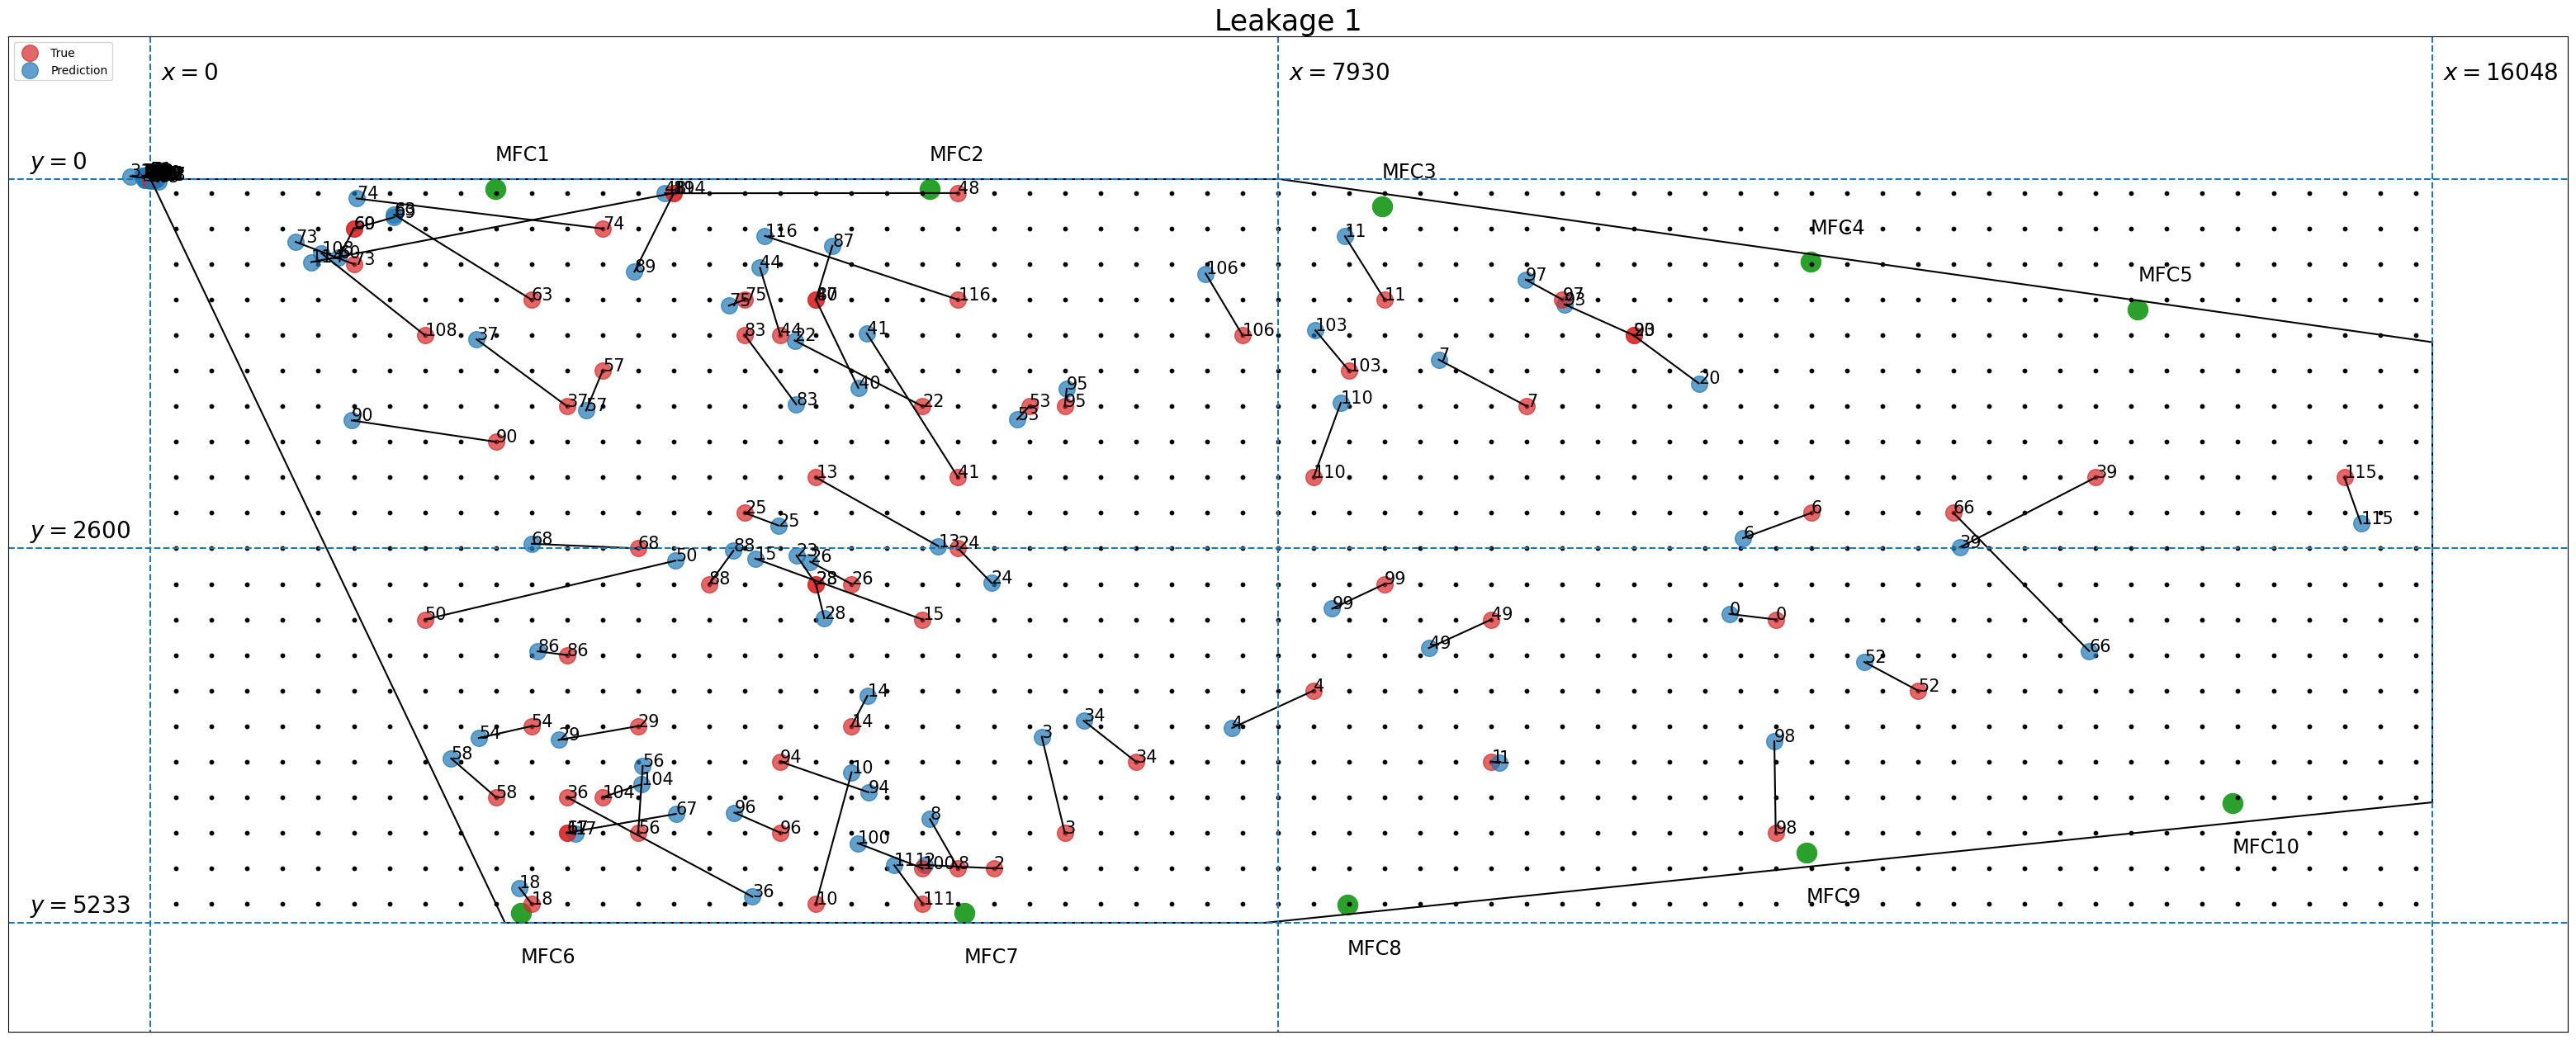

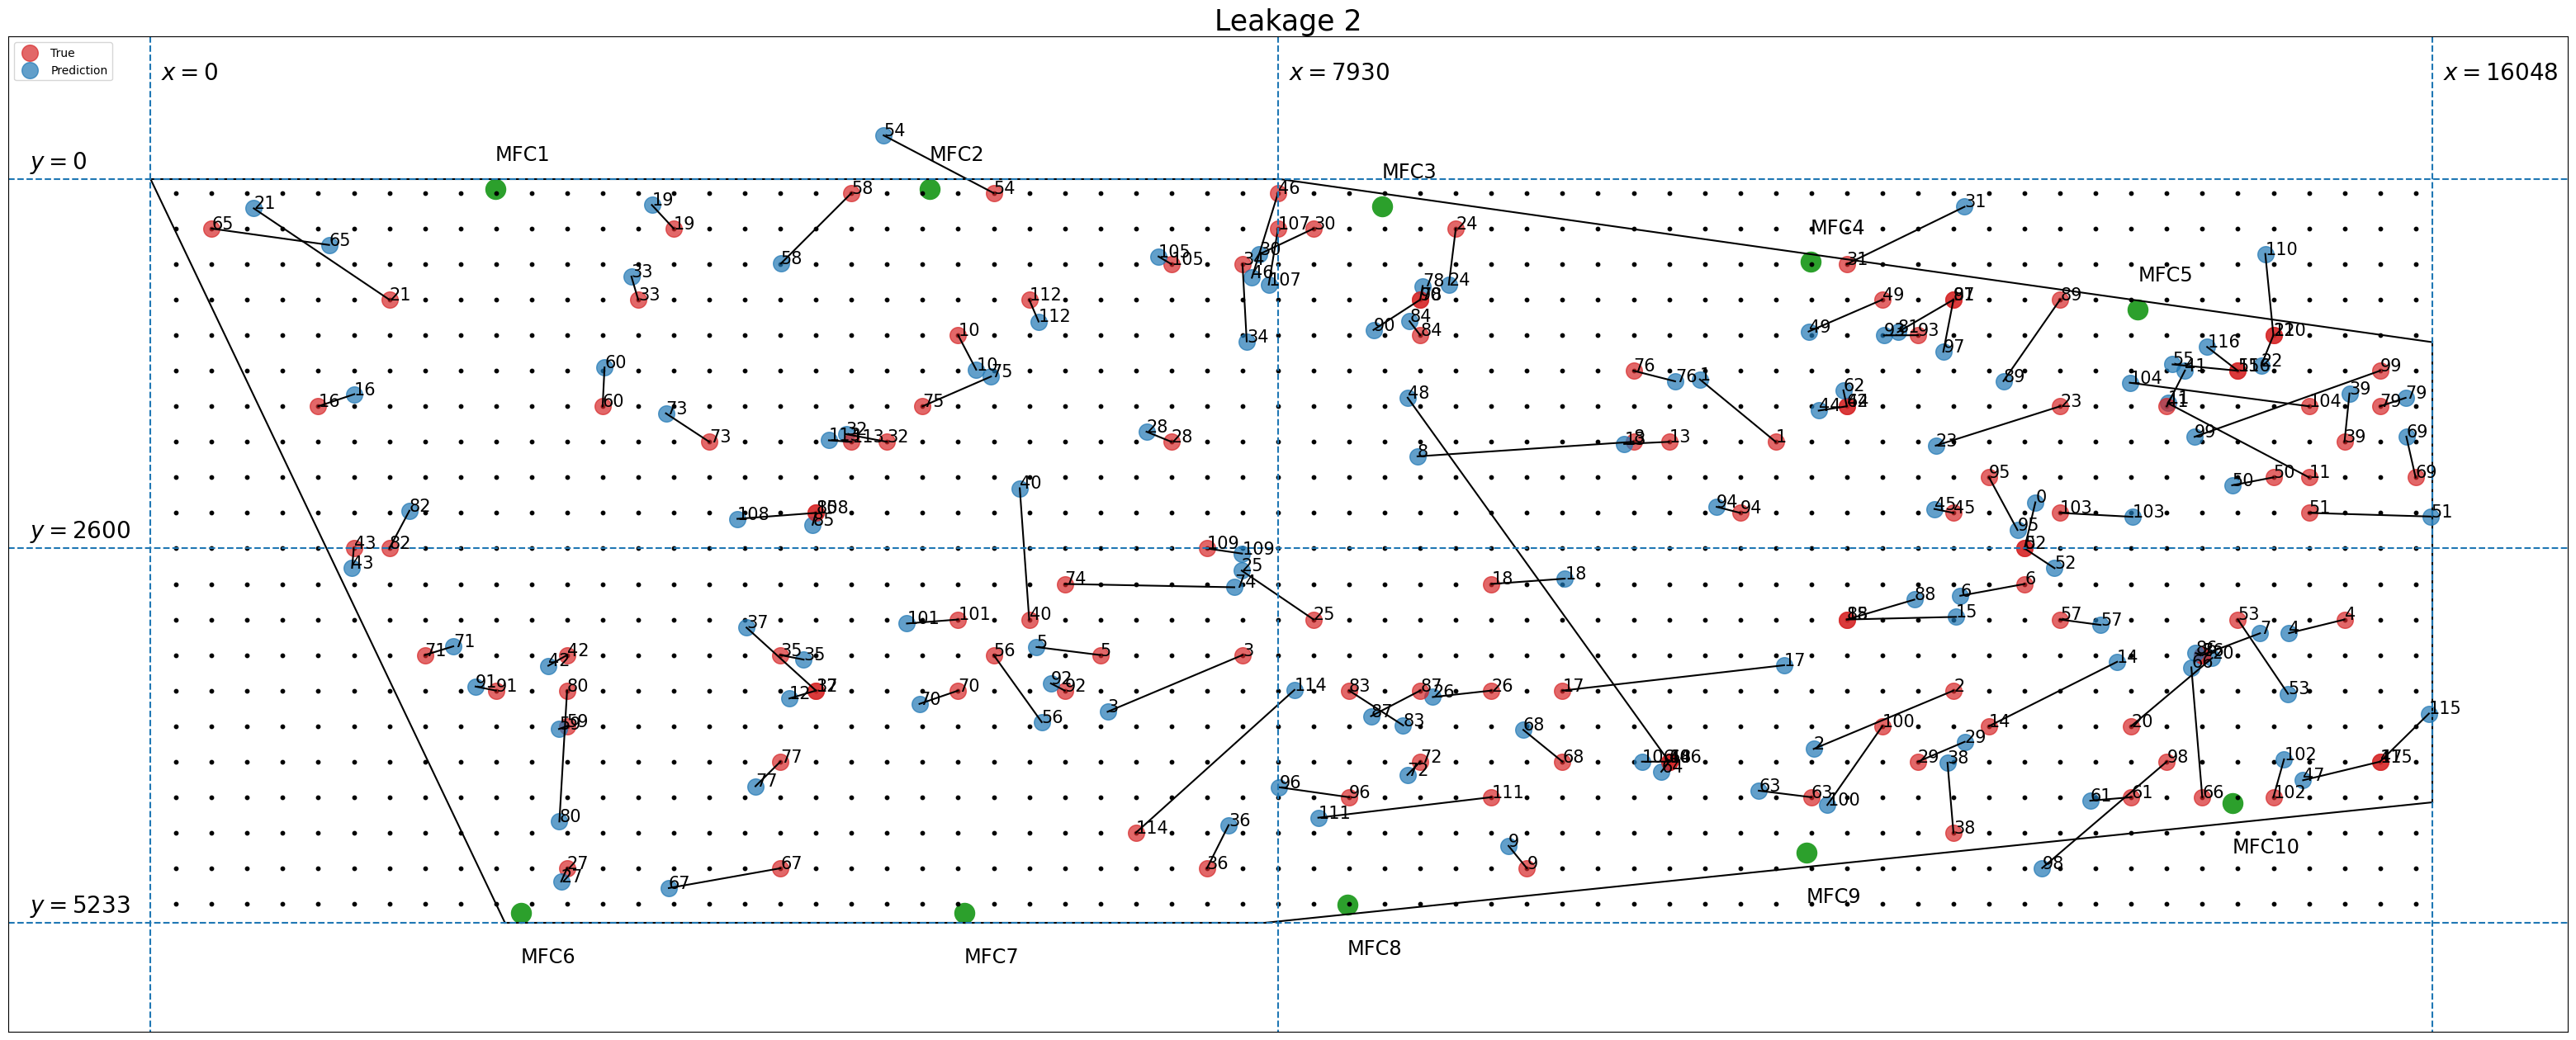

In [75]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

x_range = np.arange(180, 16048, 250)
y_range = np.arange(100, 5233, 250)
X, Y = np.meshgrid(x_range, y_range)

def plot_test_pred_uncertainity(test, pred, std, title):
    plt.figure(figsize=(40, 20))
    
    # plt.title(f'Sample Number {sample_number}', fontsize=20)
    
    # plot sensor positions
    sensors = np.array([[2426, 70], [5480, 70], [8661, 191], [11676, 584], [13976, 917], [2603, 5163], [5723, 5163], [8417, 5103], [11646, 4740], [14641, 4391]])
    for i in range(len(sensors)):
        plt.scatter(sensors[i, 0], sensors[i, 1], color='tab:green', s=300)
        if i < 5:
            plt.text(sensors[i, 0], sensors[i, 1] - 200, 'MFC'+str(i+1), fontsize='xx-large')
        else:
            plt.text(sensors[i, 0], sensors[i, 1] + 350, 'MFC'+str(i+1), fontsize='xx-large')

    # plot leakage positions
    plt.scatter(X, Y, color='black', s=10)
    
    for i in range(len(test)):
        if i != len(test)-1:
            plt.scatter(test[i][0], test[i][1], color='tab:red', s=200, alpha= 0.7)
            plt.scatter(pred[i][0], pred[i][1], s=200, color='tab:blue', alpha= 0.7)
            line = np.vstack((test[i], pred[i])).transpose()
            plt.plot(line[0], line[1], color = 'black')
            plt.annotate(str(i), (pred[i][0], pred[i][1] + 0.2), fontsize=15)
            plt.annotate(str(i), (test[i][0], test[i][1] + 0.2), fontsize=15)
        else:
            plt.scatter(test[i][0], test[i][1], color='tab:red', s=200, label="True", alpha= 0.7)
            plt.scatter(pred[i][0], pred[i][1], s=200, color='tab:blue', label= "Prediction", alpha= 0.7)
            line = np.vstack((test[i], pred[i])).transpose()
            plt.plot(line[0], line[1], color = 'black')
            plt.annotate(str(i), (pred[i][0], pred[i][1] + 0.2), fontsize=15)
            plt.annotate(str(i), (test[i][0], test[i][1] + 0.2), fontsize=15)


    for i in range(len(pred)):
        mean_x, mean_y = pred[i][0], pred[i][1]
        sigma_x, sigma_y = std[i][0], std[i][1]

        # Plot ellipses representing uncertainty
        ellipse = patches.Ellipse((mean_x, mean_y), width=2*sigma_x, height=2*sigma_y, angle=0, alpha=0.2)
        plt.gca().add_patch(ellipse)
    plt.gca().set_aspect('equal')

    plot_wing_contour()

    # include grid coordinate system
    plt.hlines(0, -1000, 17000, linestyle='dashed')
    plt.hlines(2600, -1000, 17000, linestyle='dashed')
    plt.hlines(5233, -1000, 17000, linestyle='dashed')
    plt.vlines(0, -1000, 6000, linestyle='dashed')
    plt.vlines(7930, -1000, 6000, linestyle='dashed')
    plt.vlines(16048, -1000, 6000, linestyle='dashed')
    plt.text(-850, -75, '$y = 0$', fontsize=20)
    plt.text(-850, 2600-75, '$y = 2600$', fontsize=20)
    plt.text(-850, 5233-75, '$y = 5233$', fontsize=20)
    plt.text(75, -700, '$x=0$', fontsize=20)
    plt.text(7930+75, -700, '$x=7930$', fontsize=20)
    plt.text(16048+75, -700, '$x=16048$', fontsize=20)
    # plt.text(180, 5800, f'(x1, y1) = ({x1}, {y1}) = ({j1-31}, {-i1+10})', fontsize=20)
    plt.legend(loc="upper left")
    plt.title(title, fontsize = 25)
    # invert y axis
    plt.gca().invert_yaxis()

    # lgnd = plt.legend(loc="upper left", numpoints=2, fontsize=15)

    #change the marker size manually for both lines
    # lgnd.legendHandles[0]._sizes = [30]
    # lgnd.legendHandles[1]._sizes = [30]

    plt.show()

def plot_wing_contour():
    plt.plot([0, 7930], [0, 0], 'k')
    plt.plot([7930, 16048], [0, 1149], 'k')
    plt.plot([16048, 16048], [1149, 4386], 'k')
    plt.plot([16048, 7843], [4386, 5233], 'k')
    plt.plot([7843, 2493], [5233, 5233], 'k')
    plt.plot([2493, 0], [5233, 0], 'k')
    plt.xlim([-1000, 17000])
    plt.ylim([-1000, 6000])
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_aspect('equal')


def plot_multi_leak(test, pred_mean, pred_std):
    plot_test_pred_uncertainity(test[['x1', 'y1']].to_numpy(), pred_mean[['x1', 'y1']].to_numpy(), pred_std[['x1', 'y1']].to_numpy(), 'Leakage 1')
    plot_test_pred_uncertainity(test[['x2', 'y2']].to_numpy(), pred_mean[['x2', 'y2']].to_numpy(), pred_std[['x2', 'y2']].to_numpy(), 'Leakage 2')
    plt.show()

plot_multi_leak(y_test, pred_mean, pred_std)